In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Scikit-learn libraries
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss, log_loss

# PART 3: LOGISTIC REGRESSION VS BAYES CLASSIFIER

## QUESTION 5.1

In this section, I will load the breast cancer dataset, implement **Logistic Regression**, **Bayes classifier** consider the **Naive Bayes variant** (with- out shared covariance) as well as the variants with full covariance (shared and not shared), perform a train/test split (80% train), and compare model performance.

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Display basic information
print("Feature names:", data.feature_names)
print("Target names:", data.target_names)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target names: ['malignant' 'benign']
Shape of X: (569, 30)
Shape of y: (569,)


In [3]:
# Combine features and target into a single DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Display the first 10 rows
df.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


In [4]:
class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        
        # A boolean indicating whether features are conditionally independent given the class.
        self.cond_ind=cond_ind

    def fit(self, x, y):
        # This is Unique class labels and Number of instances
        self.classes_, class_counts = np.unique(y, return_counts=True)
        
        # Number of row and col
        self.n_ , self.p_ = x.shape
        
        # Number of label
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        # Prior probabilities of each class.
        self.class_priors_ = class_counts/len(y)
        
        # Number of unique classesß
        for c in range(self.k_):
            # Boolean to create true / false 
            # where each element is True if the corresponding sample's class label is c, and False otherwise.
            c_rows = y==c
            # mean by columns
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            
            # Individual dependent True
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            # Individual dependent False
            else:
                # Population or sample (bias = True / False, n and n - 1)
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

In [5]:
# Perform Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

# Logistic Regression with regularization
lr = LogisticRegression(max_iter=10000, solver='lbfgs', C=1.0, tol=1e-4)
lr.fit(X_train, y_train)

# Bayesian Classifiers
# Naive Bayes Variant (without shared covariance)
nb = BayesianClassifier(shared_cov=False, cond_ind=True)
nb.fit(X_train, y_train)

# Bayes Classifier with Full Covariance (Shared)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False)
bc_shared.fit(X_train, y_train)

# Bayes Classifier with Full Covariance (Not shared)
bc = BayesianClassifier(shared_cov=False, cond_ind=False)
bc.fit(X_train, y_train)

# Predict probabilities and calculate loss
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    zero_one_loss_train = np.mean(y_train != y_train_pred)
    zero_one_loss_test = np.mean(y_test != y_test_pred)
    
    log_loss_train = log_loss(y_train, y_train_prob)
    log_loss_test = log_loss(y_test, y_test_prob)
    
    return zero_one_loss_train, zero_one_loss_test, log_loss_train, log_loss_test

# Evaluate models
zero_one_loss_lr_train, zero_one_loss_lr_test, log_loss_lr_train, log_loss_lr_test = evaluate_model(lr, X_train, y_train, X_test, y_test)
zero_one_loss_nb_train, zero_one_loss_nb_test, log_loss_nb_train, log_loss_nb_test = evaluate_model(nb, X_train, y_train, X_test, y_test)
zero_one_loss_bc_shared_train, zero_one_loss_bc_shared_test, log_loss_bc_shared_train, log_loss_bc_shared_test = evaluate_model(bc_shared, X_train, y_train, X_test, y_test)
zero_one_loss_bc_train, zero_one_loss_bc_test, log_loss_bc_train, log_loss_bc_test = evaluate_model(bc, X_train, y_train, X_test, y_test)

# Report results
results = {
    'Model': ['Logistic Regression', 'Naive Bayes (No Shared Cov)', 'Bayes (Full Cov Shared)', 'Bayes (Full Cov Not Shared)'],
    'Train Zero-One Loss': [zero_one_loss_lr_train, zero_one_loss_nb_train, zero_one_loss_bc_shared_train, zero_one_loss_bc_train],
    'Test Zero-One Loss': [zero_one_loss_lr_test, zero_one_loss_nb_test, zero_one_loss_bc_shared_test, zero_one_loss_bc_test],
    'Train Log Loss': [log_loss_lr_train, log_loss_nb_train, log_loss_bc_shared_train, log_loss_bc_train],
    'Test Log Loss': [log_loss_lr_test, log_loss_nb_test, log_loss_bc_shared_test, log_loss_bc_test]
}

results_df = pd.DataFrame(results)
results_df



,Model,Train Zero-One Loss,Test Zero-One Loss,Train Log Loss,Test Log Loss
0,Logistic Regression,0.037363,0.043860,0.092129,0.080016
1,Naive Bayes (No Shared Cov),0.072527,0.043860,1.418278,0.889315
2,Bayes (Full Cov Shared),0.037363,0.043860,0.172881,0.081735
3,Bayes (Full Cov Not Shared),0.057143,0.078947,1.067798,2.086165


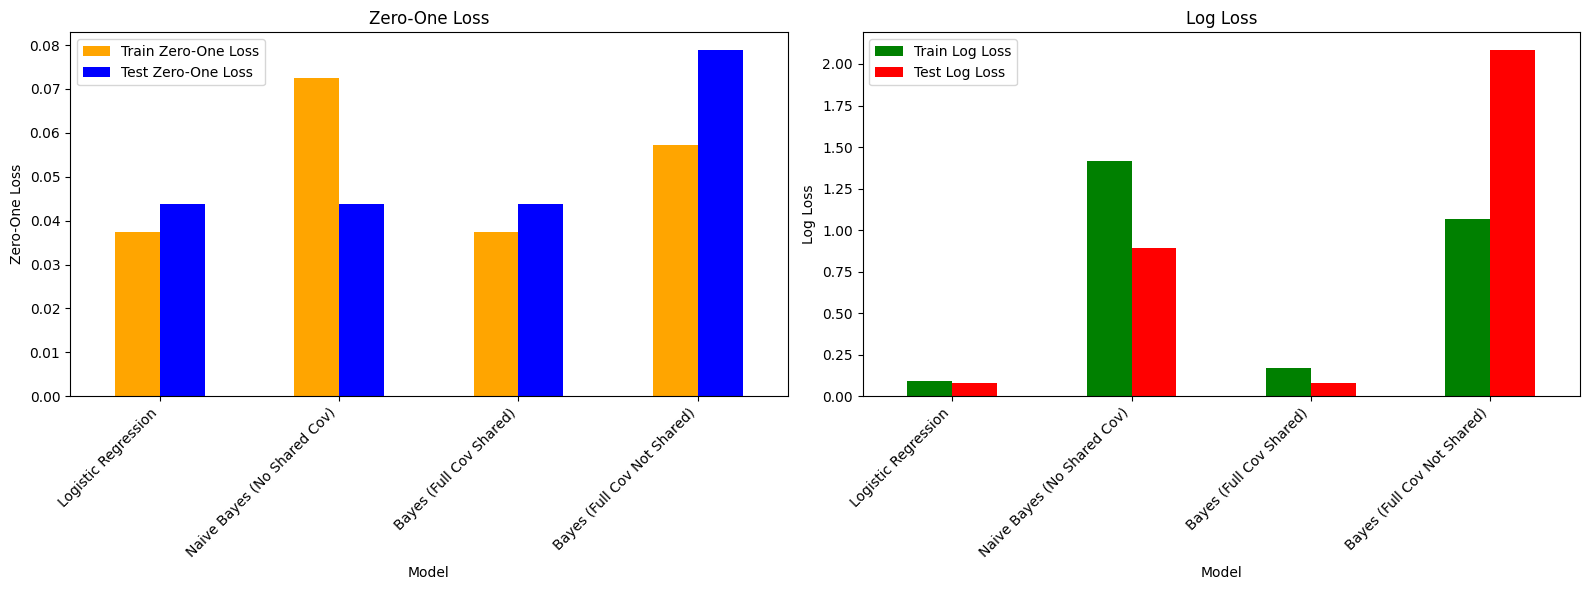

In [6]:
# Plot Zero-One Loss
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Zero-One Loss Plot
results_df.plot(kind='bar', x='Model', y=['Train Zero-One Loss', 'Test Zero-One Loss'], ax=ax[0], color=['orange', 'blue'], legend=True)
ax[0].set_title('Zero-One Loss')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Zero-One Loss')
ax[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')

# Log Loss Plot
results_df.plot(kind='bar', x='Model', y=['Train Log Loss', 'Test Log Loss'], ax=ax[1], color=['green', 'red'], legend=True)
ax[1].set_title('Log Loss')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Log Loss')
ax[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

I create this chart to compare Zero-One Loss (left plot) and Log Loss (right plot) for different models, including Logistic Regression, Naive Bayes (No Shared Covariance), and Bayes classifiers (Shared and Not Shared Covariance), for both training and test sets.

# Key Observations:
## 1. Zero-One Loss:
- **Logistic Regression** has the lowest loss for both training and test sets.
- **Naive Bayes (No Shared Covariance)** shows the highest training loss, while **Bayes (Full Covariance Not Shared)** has the highest test loss, indicating potential overfitting.
- The models generally perform better on the training set than on the test set, showing higher test losses.
## 2. Log Loss:
- **Logistic Regression** performs the best with the lowest Log Loss for both training and test sets.
- **Naive Bayes (No Shared Covariance)** and **Bayes models** show significantly higher log losses, particularly for the test set, with the highest being **Bayes (Full Covariance Not Shared)**, suggesting poor model generalization.

In summary, Logistic Regression performs best across both metrics, with the Bayes classifiers showing varying degrees of overfitting.

## Question 5.2

In this section, I try to evaluate the performance of **Logistic Regression**, **Naive Bayes**, and **Bayesian Classifiers** across different training sizes by measuring Zero-One Loss and Log Loss for both training and test sets. It runs the experiment for each training size 10 times, records predictions for each model, and computes the mean loss metrics. The results are stored in a DataFrame for analysis, providing insights into model performance as training size varies.

In [9]:
# Define parameters
training_sizes = list(range(5, 501, 5))
num_repeats = 10
results = []

# Experiment loop
for N in training_sizes:
    zero_one_loss_lr_default_train = []
    zero_one_loss_lr_default_test = []
    zero_one_loss_nb_train = []
    zero_one_loss_nb_test = []
    zero_one_loss_nb_shared_train = []
    zero_one_loss_nb_shared_test = []
    zero_one_loss_bc_train = []
    zero_one_loss_bc_test = []
    
    log_loss_lr_default_train = []
    log_loss_lr_default_test = []
    log_loss_nb_train = []
    log_loss_nb_test = []
    log_loss_nb_shared_train = []
    log_loss_nb_shared_test = []
    log_loss_bc_train = []
    log_loss_bc_test = []
    
    for _ in range(num_repeats):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=N, shuffle=True, random_state=42)
        
        # **Logistic Regression (default)**
        lr_default = LogisticRegression(max_iter=1000)
        lr_default.fit(X_train, y_train)
        
        # Bayesian Classifiers
        # Naive Bayes Variant (without shared covariance)
        nb = BayesianClassifier(shared_cov=False, cond_ind=True)
        nb.fit(X_train, y_train)

        # Bayes Classifier with Full Covariance (Shared)
        bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False)
        bc_shared.fit(X_train, y_train)

        # Bayes Classifier with Full Covariance (Not shared)
        bc = BayesianClassifier(shared_cov=False, cond_ind=False)
        bc.fit(X_train, y_train)
        
        # Predict and evaluate
        y_train_pred_lr_default = lr_default.predict(X_train)
        y_test_pred_lr_default = lr_default.predict(X_test)
        
        y_train_pred_nb = nb.predict(X_train)
        y_test_pred_nb = nb.predict(X_test)
        
        y_train_pred_nb_shared = bc_shared.predict(X_train)
        y_test_pred_nb_shared = bc_shared.predict(X_test)
        
        y_train_pred_bc = bc.predict(X_train)
        y_test_pred_bc = bc.predict(X_test)         
        
        # Calculate probabilities for log_loss
        y_train_prob_lr_default = lr_default.predict_proba(X_train)[:, 1]
        y_test_prob_lr_default = lr_default.predict_proba(X_test)[:, 1]
        
        y_train_prob_nb = nb.predict_proba(X_train)[:, 1]
        y_test_prob_nb = nb.predict_proba(X_test)[:, 1]
        
        y_train_prob_nb_shared = bc_shared.predict_proba(X_train)[:, 1]
        y_test_prob_nb_shared = bc_shared.predict_proba(X_test)[:, 1]
        
        y_train_prob_bc = bc.predict_proba(X_train)[:, 1]
        y_test_prob_bc = bc.predict_proba(X_test)[:, 1]
        
        # Compute zero-one loss
        zero_one_loss_lr_default_train.append(zero_one_loss(y_train, y_train_pred_lr_default))
        zero_one_loss_lr_default_test.append(zero_one_loss(y_test, y_test_pred_lr_default))
        
        zero_one_loss_nb_train.append(zero_one_loss(y_train, y_train_pred_nb))
        zero_one_loss_nb_test.append(zero_one_loss(y_test, y_test_pred_nb))
        
        zero_one_loss_nb_shared_train.append(zero_one_loss(y_train, y_train_pred_nb_shared))
        zero_one_loss_nb_shared_test.append(zero_one_loss(y_test, y_test_pred_nb_shared))
        
        zero_one_loss_bc_train.append(zero_one_loss(y_train, y_train_pred_bc))
        zero_one_loss_bc_test.append(zero_one_loss(y_test, y_test_pred_bc))
        
        # Compute log loss
        log_loss_lr_default_train.append(log_loss(y_train, y_train_prob_lr_default))
        log_loss_lr_default_test.append(log_loss(y_test, y_test_prob_lr_default))
        
        log_loss_nb_train.append(log_loss(y_train, y_train_prob_nb))
        log_loss_nb_test.append(log_loss(y_test, y_test_prob_nb))
        
        log_loss_nb_shared_train.append(log_loss(y_train, y_train_prob_nb_shared))
        log_loss_nb_shared_test.append(log_loss(y_test, y_test_prob_nb_shared))
        
        log_loss_bc_train.append(log_loss(y_train, y_train_prob_bc))
        log_loss_bc_test.append(log_loss(y_test, y_test_prob_bc))
    
        results.append({
            'training_size': N,
            'zero_one_loss_lr_default_train': np.mean(zero_one_loss_lr_default_train),
            'zero_one_loss_lr_default_test': np.mean(zero_one_loss_lr_default_test),
            'zero_one_loss_nb_train': np.mean(zero_one_loss_nb_train),
            'zero_one_loss_nb_test': np.mean(zero_one_loss_nb_test),
            'zero_one_loss_nb_shared_train': np.mean(zero_one_loss_nb_shared_train),
            'zero_one_loss_nb_shared_test': np.mean(zero_one_loss_nb_shared_test),
            
            'log_loss_lr_default_train': np.mean(log_loss_lr_default_train),
            'log_loss_lr_default_test': np.mean(log_loss_lr_default_test),
            'log_loss_nb_train': np.mean(log_loss_nb_train),
            'log_loss_nb_test': np.mean(log_loss_nb_test),
            'log_loss_nb_shared_train': np.mean(log_loss_nb_shared_train),
            'log_loss_nb_shared_test': np.mean(log_loss_nb_shared_test),
            
            'zero_one_loss_bc_train': np.mean(zero_one_loss_bc_train),
            'zero_one_loss_bc_test': np.mean(zero_one_loss_bc_test),
            'log_loss_bc_train': np.mean(log_loss_bc_train),
            'log_loss_bc_test': np.mean(log_loss_bc_test),
        })

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results)
results_df.head(15)


,training_size,zero_one_loss_lr_default_train,zero_one_loss_lr_default_test,zero_one_loss_nb_train,zero_one_loss_nb_test,zero_one_loss_nb_shared_train,zero_one_loss_nb_shared_test,log_loss_lr_default_train,log_loss_lr_default_test,log_loss_nb_train,log_loss_nb_test,log_loss_nb_shared_train,log_loss_nb_shared_test,zero_one_loss_bc_train,zero_one_loss_bc_test,log_loss_bc_train,log_loss_bc_test
0,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
1,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
2,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
3,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
4,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
5,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
6,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
7,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
8,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237
9,5,0.0,0.095745,0.2,0.356383,0.0,0.625887,0.000174,0.605659,7.208731,12.845345,2.220446e-16,22.559237,0.0,0.625887,2.220446e-16,22.559237


## QUESTION 5.3

This section I create four subplots to visualize the Zero-One Loss and Log Loss for different models (Logistic Regression, Naive Bayes, and Bayesian Classifiers). It shows both the training and test performance for each model, helping compare their performance as the amount of training data increases. After that, I will answer the questions from the charts.

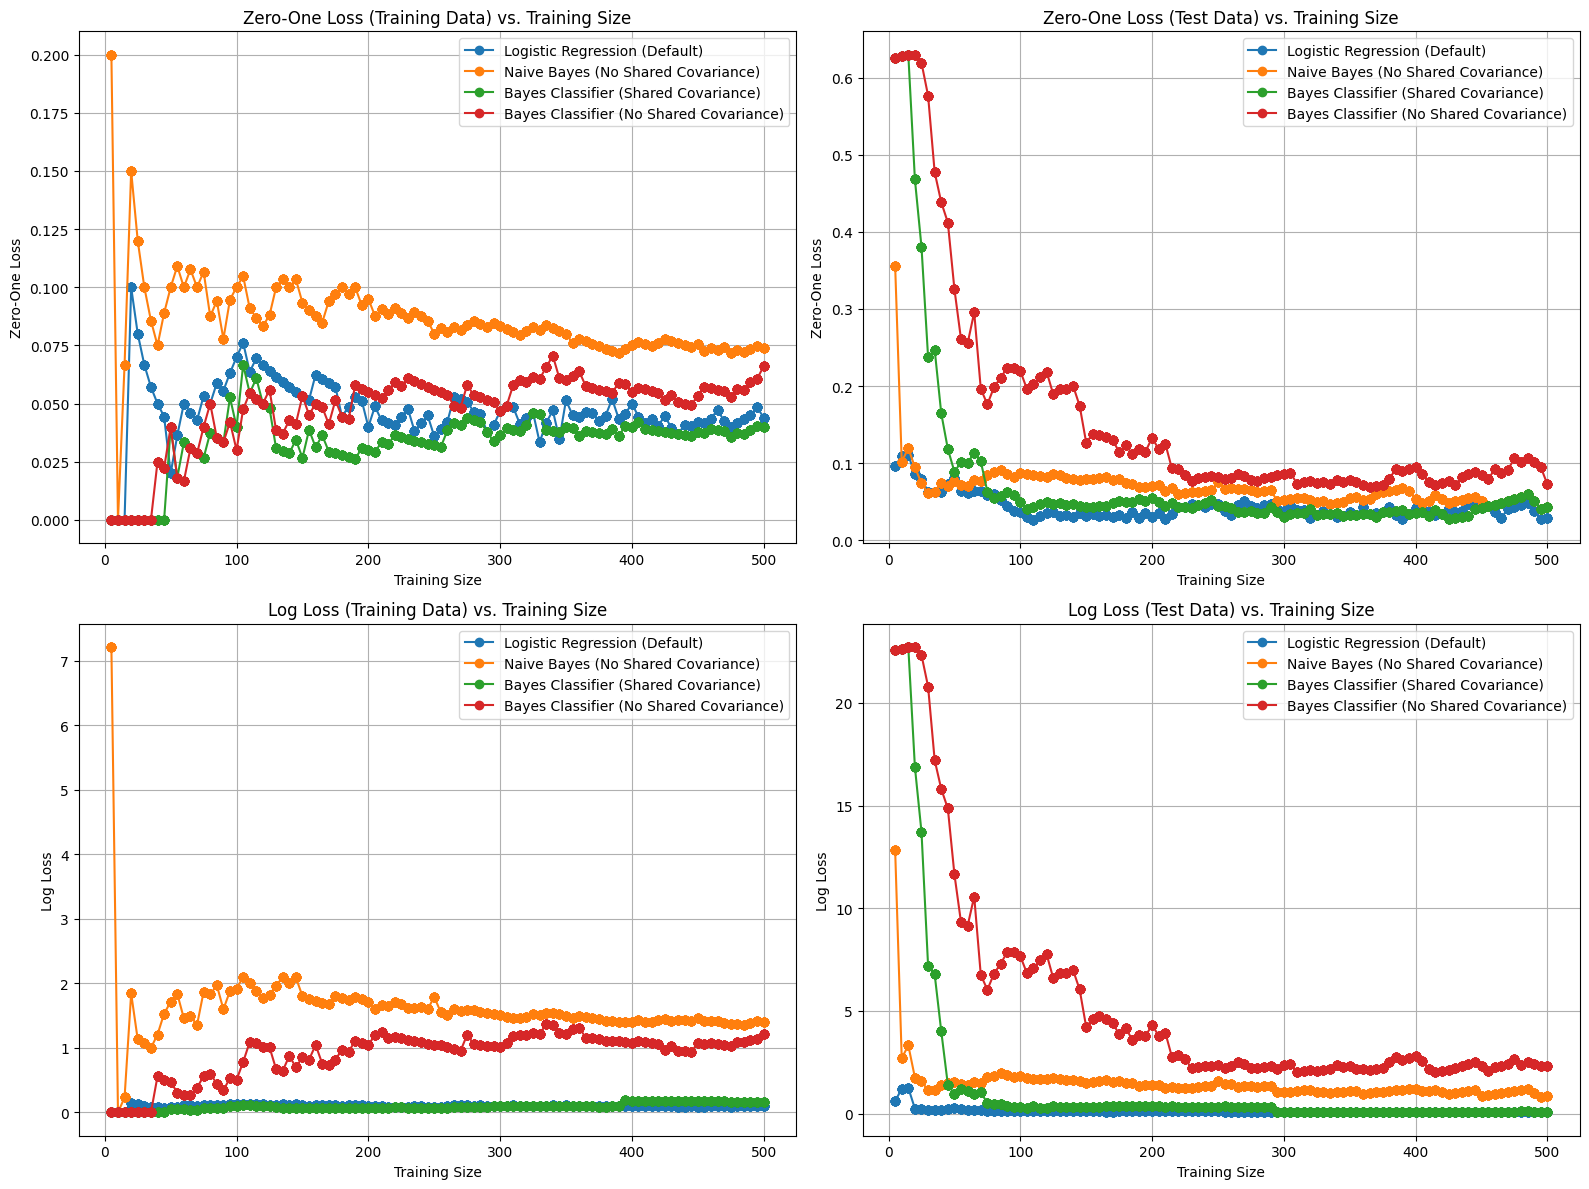

In [11]:
import matplotlib.pyplot as plt

# Create a new figure with subplots for training and test data
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot Zero-One Loss for Training Data
axs[0, 0].plot(results_df['training_size'], results_df['zero_one_loss_lr_default_train'], label='**Logistic Regression (default)**', marker='o')
axs[0, 0].plot(results_df['training_size'], results_df['zero_one_loss_nb_train'], label='**Naive Bayes (No Shared Covariance)**', marker='o')
axs[0, 0].plot(results_df['training_size'], results_df['zero_one_loss_nb_shared_train'], label='**Bayes Classifier (Shared Covariance)**', marker='o')
axs[0, 0].plot(results_df['training_size'], results_df['zero_one_loss_bc_train'], label='**Bayes Classifier (No Shared Covariance)**', marker='o')
axs[0, 0].set_title('Zero-One Loss (Training Data) vs. Training Size')
axs[0, 0].set_xlabel('Training Size')
axs[0, 0].set_ylabel('Zero-One Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Zero-One Loss for Test Data
axs[0, 1].plot(results_df['training_size'], results_df['zero_one_loss_lr_default_test'], label='**Logistic Regression (default)**', marker='o')
axs[0, 1].plot(results_df['training_size'], results_df['zero_one_loss_nb_test'], label='**Naive Bayes (No Shared Covariance)**', marker='o')
axs[0, 1].plot(results_df['training_size'], results_df['zero_one_loss_nb_shared_test'], label='**Bayes Classifier (Shared Covariance)**', marker='o')
axs[0, 1].plot(results_df['training_size'], results_df['zero_one_loss_bc_test'], label='**Bayes Classifier (No Shared Covariance)**', marker='o')
axs[0, 1].set_title('Zero-One Loss (Test Data) vs. Training Size')
axs[0, 1].set_xlabel('Training Size')
axs[0, 1].set_ylabel('Zero-One Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Log Loss for Training Data
axs[1, 0].plot(results_df['training_size'], results_df['log_loss_lr_default_train'], label='**Logistic Regression (default)**', marker='o')
axs[1, 0].plot(results_df['training_size'], results_df['log_loss_nb_train'], label='**Naive Bayes (No Shared Covariance)**', marker='o')
axs[1, 0].plot(results_df['training_size'], results_df['log_loss_nb_shared_train'], label='**Bayes Classifier (Shared Covariance)**', marker='o')
axs[1, 0].plot(results_df['training_size'], results_df['log_loss_bc_train'], label='**Bayes Classifier (No Shared Covariance)**', marker='o')
axs[1, 0].set_title('Log Loss (Training Data) vs. Training Size')
axs[1, 0].set_xlabel('Training Size')
axs[1, 0].set_ylabel('Log Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot Log Loss for Test Data
axs[1, 1].plot(results_df['training_size'], results_df['log_loss_lr_default_test'], label='**Logistic Regression (default)**', marker='o')
axs[1, 1].plot(results_df['training_size'], results_df['log_loss_nb_test'], label='**Naive Bayes (No Shared Covariance)**', marker='o')
axs[1, 1].plot(results_df['training_size'], results_df['log_loss_nb_shared_test'], label='**Bayes Classifier (Shared Covariance)**', marker='o')
axs[1, 1].plot(results_df['training_size'], results_df['log_loss_bc_test'], label='**Bayes Classifier (No Shared Covariance)**', marker='o')
axs[1, 1].set_title('Log Loss (Test Data) vs. Training Size')
axs[1, 1].set_xlabel('Training Size')
axs[1, 1].set_ylabel('Log Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# a) What happens to each classifier's training and test performance when the number of training data points is increased?
## Training Performance:
- **Logistic Regression (default)**: As the training size increases, the zero one loss and log loss both decrease for training data. Initially, with small training sizes, there's fluctuation, but as the data size grows, the model stabilizes.

- **Naive Bayes (No Shared Covariance)**: Zero-one loss is low, but as training size increases, it slightly increases before stabilizing, indicating that it quickly learns patterns, but is sensitive to the training size.

- **Bayes Classifier (Shared Covariance)**: The training performance is stable and efficient as the training size grows, showing that the model is robust in learning from more data.

- **Bayes Classifier (No Shared Covariance)**: Performs poorly initially but improves as training data increases, showing large fluctuations when training size is small, and more stable at large data points. 

## Test Performance:

- **Logistic Regression (default)**: Shows a rapid improvement in test performance with larger training sizes and quickly stabilizes, indicating good generalization (around 0.5 in zero one loss and near 0 at log loss).

- **Naive Bayes (No Shared Covariance)**: Performs well with small fluctuations and stabilizes with increasing training size but still lowest out of 4.

- **Bayes Classifier (Shared Covariance)**: Demonstrates improvement in test performance as data increases, showing consistent behavior (around 0.5 in zero one loss and near 0 at log loss).

- **Bayes Classifier (No Shared Covariance)**: Shows poor performance for smaller training sets, with fluctuations. As the training size increases, the test performance improves and stabilizes (around 0.6-0.7 in zero one loss) but still lower than **Logistic Regression (default)** and **Bayes Classifier (Shared Covariance)**.

# b) Which classifier is best suited when the training set is small, and which is best suited when the training set is big?
## Small Training Set:
- **Naive Bayes (No Shared Covariance)** performs relatively well when the training set is small, based on the zero-one loss and log loss (around 0.07 and 2.5 respective in Test data).

- **Logistic Regression** also stabilizes early on, making it a good option for small training sets (around 0.7 and 0 respective in Test data).
## Big Training Set:
- **Bayes Classifier (Shared Covariance)** performs well as the training size increases. It stabilizes with the largest training sizes and maintains good generalization performance (around 0.05 and 0 respective in Test data). 

- **Logistic Regression** also performs well with large training sizes, showing stable and low loss metrics (around 0.05 and 0.1 respective in Test data).


# c) Justify your observations by providing some speculations and possible reasons.
## Model Complexity and Parameters:
- **Naive Bayes (No Shared Covariance)** assumes conditional independence between features, which makes it perform well even with small datasets. However, as the data size grows, the assumption of independence might not hold, which may explain the slight increase in training loss before stabilizing.
- Logistic Regression learns a linear decision boundary and requires a larger training set to learn its weights properly. With small datasets, it can suffer from high variance, but with larger datasets, it generalizes well due to its relatively simple model structure.

- **Bayes Classifier (Shared Covariance)**, with shared covariance, is a simpler model compared to the version with no shared covariance. It requires fewer parameters and makes fewer assumptions, allowing it to perform well even with larger datasets.

- **Bayes Classifier (No Shared Covariance)** is a complex model with many parameters to estimate. It requires more data to avoid overfitting and to learn the covariance structure. With a small training set, it struggles, but as the dataset grows, the model is able to learn more effectively. 

## Assumptions and Data Complexity:
- Models like **Naive Bayes** make strong assumptions about feature independence, which can be beneficial when the training set is small. However, these assumptions may not hold in complex datasets, making it perform worse on larger training sets.

- **Logistic Regression** is flexible but requires enough data to effectively model the underlying distribution. Its linear nature means that it can perform well with both small and large datasets, provided the underlying relationships in the data are relatively simple.

- **Bayes Classifiers**, especially with no shared covariance, are prone to overfitting when the training set is small because they try to learn complex structures. As the training set grows, the model has enough data to support the complexity, leading to improved performance.



# In summary:
- **Naive Bayes** works best with small datasets due to its simplicity and strong assumptions.
- **Logistic Regression** is a robust performer for both small and large datasets.
- **Bayes Classifier** with shared covariance scales well with large datasets and provides reliable performance when there is enough data to learn covariance structures.